In [2]:
import pandas as pd
import numpy as np
import json
import re
from tqdm.notebook import tqdm
import pymongo
from collections import Counter


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import defaultdict
import nltk
from nltk.corpus import stopwords
#print stop words
# print(stopwords.words('english'))

In [4]:
import pycountry
import plotly.express as px


In [5]:
# conncet to DB
myclient = pymongo.MongoClient("mongodb://localhost:27017/") 
mydb = myclient["bdt_db"] 
mycol = mydb["birth_tweets"] 


In [6]:
# read all tweets of the database
tweets = [t for t in mycol.find({})]

In [50]:
tweets[890]

{'_id': 1206957790947921923,
 'ID': 1206957790947921923,
 'time': '2019-12-17',
 'username': 'DaveFincher1984',
 'text': '🎄 Christmas Came Early 🎄Welcome to the world...Lily Faith Fincher 💕 She entered the world at 9.42am this morning, weighing 7lbs 3oz. Both mum and baby doing great. Mum was amazing in Labour having been awake over 24 hours 👏  Welcome to the family 💕 https://t.co/7KoGBriQgV',
 'permalink': 'https://twitter.com/DaveFincher1984/status/1206957790947921923',
 'location': 'Croatia'}

In [19]:
len(tweets)

418460

In [73]:
countries = defaultdict(int)
for t in tweets:
    countries[t["location"]] +=1
    


In [74]:
# get countries which have twees >= 50
european_countries=set()
for c,count in countries.items():
    if count >49 and c != "":
        european_countries.add(c)
len(european_countries)

40

In [27]:
# word counter and lowecasing 
countries_word_counter = defaultdict(Counter) 
for tweet in tqdm(tweets):
    if tweet["location"] in european_countries:
        text = tweet["text"]
        text = re.sub(r"http\S+",'', text, flags=re.MULTILINE)
        text = re.sub(r"[^A-Za-z0-9'\ ]+", '', text) 
        countries_word_counter[tweet["location"]].update(text.lower().split())


In [23]:
# word_counter.most_common(30)

In [32]:
# remove stopwords
for word in stopwords.words("english"):
    for country in countries_word_counter:
        del countries_word_counter[country][word]

In [71]:
# countries_word_counter["Italy"].most_common(30)

In [59]:
# Create a WordCloud object
countries_wordCloud = dict()
for c in european_countries:
    wordcloud = WordCloud(background_color="#FAEBD7", max_words=5000, contour_width=10, contour_color='steelblue')
    # Generate a word cloud
    wordcloud.generate_from_frequencies(countries_word_counter[c])
    countries_wordCloud[c] = wordcloud

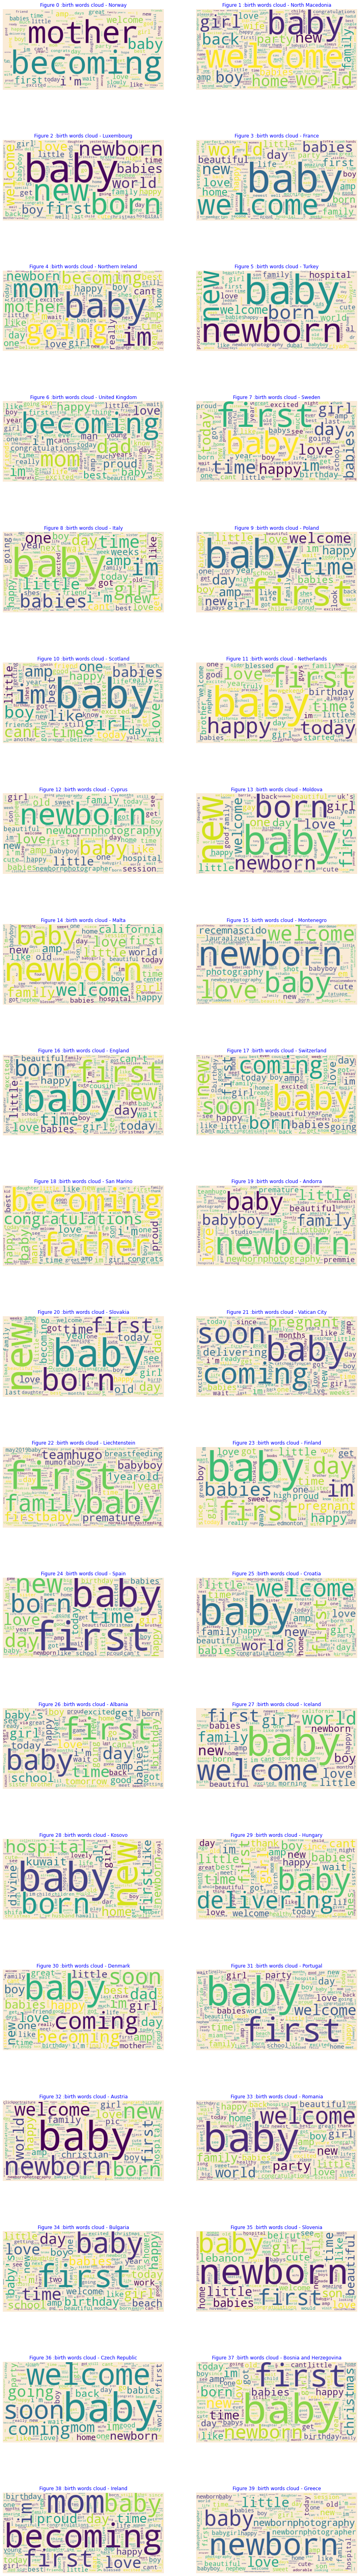

In [60]:
# Visualize the word cloud
fig,axs = plt.subplots(nrows = 20,ncols = 2,figsize = (16,6*20))
for i,(c,wordcloud) in enumerate(countries_wordCloud.items()):
    axs[i//2][i%2].imshow(wordcloud.to_image())
    axs[i//2][i%2].axis('off')
    axs[i//2][i%2].set_title('Figure {} :birth words cloud - {}'.format(i,c),color="blue" )
plt.show()


In [121]:
countries_tweet = defaultdict(int)
for t in tweets:
    countries_tweet[t["location"]] += 1

In [151]:
alpha3s = {}
isoCods = {}
for country in pycountry.countries:
    alpha3s[country.name] = country.alpha_3
    isoCods[country.name] = country.alpha_2


In [167]:

def plot_map(dd_df, title):
    hover_text = []
    for index, row in dd_df.iterrows():
        hover_text.append((f"country: {row['country']}<br>tweets: {row['tweets']}\
                          <br>country code: {row['iso']}<br>country alpha3: {row['alpha3']}"))
    dd_df['hover_text'] = hover_text

    fig = px.choropleth(dd_df, 
                        locations="alpha3",
                        hover_name='hover_text',
                        color="tweets",
                        projection="natural earth",
                        color_continuous_scale=px.colors.sequential.Plasma,
                        width=900, height=700)
    fig.update_geos(   
        showcoastlines=True, coastlinecolor="DarkBlue",
        scope =  "europe",
        resolution = 110,
        fitbounds= "locations",
        visible = True,
        showland=True, landcolor="LightGrey",
        showocean=True, oceancolor="LightBlue",
        showlakes=True, lakecolor="Blue",
        showrivers=True, rivercolor="Blue",
        showcountries=True, countrycolor="DarkBlue"
    )
    fig.update_layout(title = title, geo_scope="world")
    fig.show()  

In [168]:
d = {"country":[],"tweets":[],"alpha3":[],"iso":[]}
for c in european_countries:
    if c in alpha3s:
        alpha3_ = alpha3s.get(c)
        d["country"].append(c)
        d["tweets"].append(countries_tweet[c])
        d["alpha3"].append(alpha3_)
        d["iso"].append(isoCods.get(c))
tweet_df = pd.DataFrame(d)
tweet_df.head()

country  tweets alpha3 iso
0           Norway     287    NOR  NO
1  North Macedonia   61420    MKD  MK
2       Luxembourg      77    LUX  LU
3           France      95    FRA  FR
4           Turkey     556    TUR  TR

In [169]:
plot_map(tweet_df, "Tweets per country (where country is specified)")
